In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from nbodykit.lab import *
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mk_Gaussian_Catalog import GenerateGRF

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

%matplotlib inline
plt.style.use('dark_background')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 22
print("Import necessary libraries and packages")

Import necessary libraries and packages


## Create and Save Data

We must create our Gaussian Random Field, this field was created using Jiamin Hou's Code. Her code utilizes Nbodykit to construct a mesh which we can use. The power spectrum is that of Planck15 at a redshift of $z = 0.57$

In [2]:
Nmesh = 64
cname = '/Users/jamessunseri/desktop/uf_reu/4pcf_ISM/Testing/'
cname_dfield = 'deltar'
cname_GRF = 'GRF_data'
Pk_in = None

grf = GenerateGRF(Nmesh, Pk_in=Pk_in, do_inv_phase=True, cname=cname, 
                  cname_GRF=cname_GRF,cname_dfield = cname_dfield)
grf.run_mk_catalog_grf_weighted(do_save_catalog=True)

#obj= 587071 vol=3.900000 [Gpc/h]^3 lbox=1574.000000 [Mpc/h] nbar= 0.00015053102564102565


/Users/jamessunseri/anaconda3/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/Users/jamessunseri/anaconda3/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


## Load Data

In [3]:
data_GRF = np.loadtxt(cname_GRF + '.txt')
GRF_Catalog = ArrayCatalog({'Position':data_GRF[:,0:3]}, attrs='ext')
GRF_Catalog['Weight'] = data_GRF[:,3]

In [4]:
density_field = np.load(cname_dfield + '.npy')
print("Loading in our GRF, it has dimensions of " + str(np.shape(density_field)))

Loading in our GRF, it has dimensions of (64, 64, 64)


### Taking a Peek

Lets take a look at our field and make sure it looks like a GRF (aka white noise)

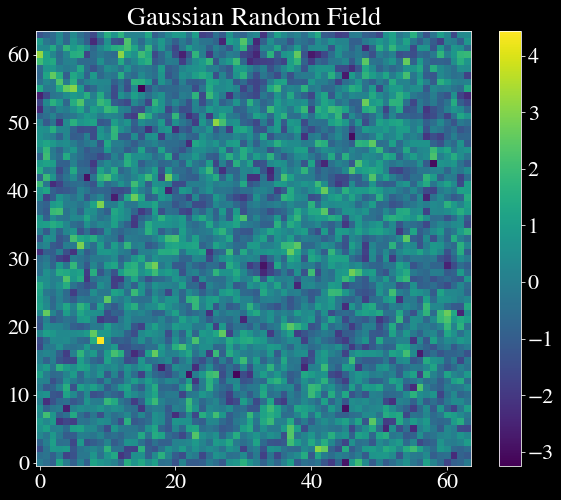

In [5]:
plt.figure(figsize=(10,8))
plt.imshow(density_field[:,:,32], origin='lower')
plt.title("Gaussian Random Field")
plt.colorbar()
plt.show()

## Measuring the Power Spectrum from the GRF

Taking Jiamin's catalog produced by her code and turning it into a GRF Mesh. Then we measure the power spectrum of said mesh.

In [6]:
GRF_Mesh = GRF_Catalog.to_mesh(Nmesh=64, BoxSize=1574, weight="Weight", resampler='cic', compensated=True)

result = FFTPower(GRF_Mesh, mode='1d')

Pk = result.power
for k in Pk.attrs:
    print("%s = %s" %(k, str(Pk.attrs[k])))

Nmesh = [64 64 64]
BoxSize = [1574. 1574. 1574.]
Lx = 1574.0
Ly = 1574.0
Lz = 1574.0
volume = 3899547224.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.003991858517903168
kmin = 0.0
kmax = None
N1 = 587071
N2 = 587071
shotnoise = 12973.247695449209


### Compare Measured Power Spectrum to Input Power Spectrum


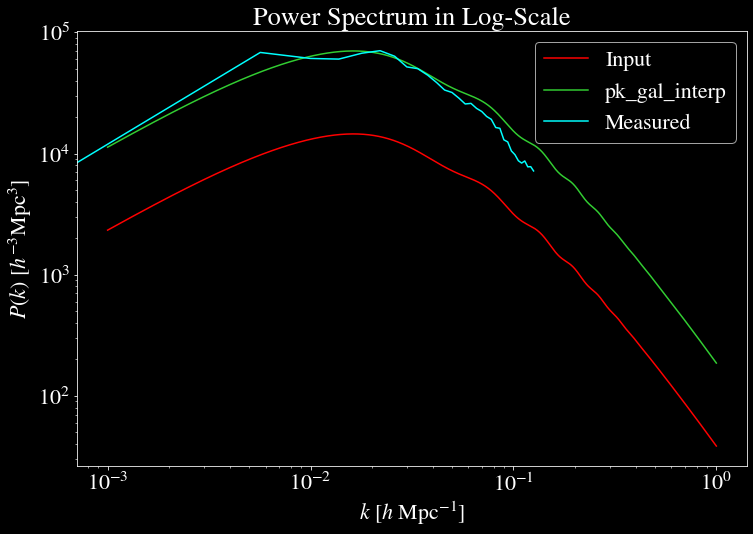

In [7]:
k = np.logspace(-3,0,1000)
power_spectrum = grf.Plin.__call__(k)
pk_gal_interp = grf.Pk_gal_interp(k)
plt.figure(figsize=(12,8))
plt.title("Power Spectrum in Log-Scale")
plt.loglog(k, power_spectrum, color='red', label='Input')
plt.loglog(k, pk_gal_interp, color='limegreen', label='pk_gal_interp')
plt.loglog((Pk['k']), (Pk['power'].real - Pk.attrs['shotnoise']), color='cyan', label='Measured')
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.legend()
plt.show()

# Creating 4PCF Coefficients with Jiamin's Code

First we need to use NbodyKit to calculate the 2PCF coefficients

In [8]:
from nbodykit.cosmology.correlation import *
import nbodykit.algorithms.paircount_tpcf.tpcf as _2pcf

Import the bounds and edges we apply for our 4pcf

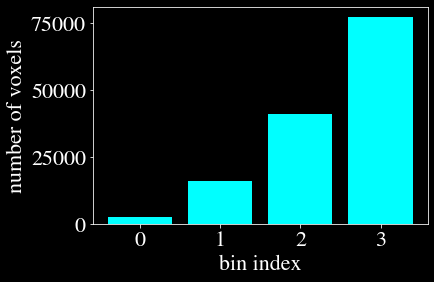

The bin edges are:
[ 0.99999   8.749995 16.5      24.250005 32.00001 ]


In [9]:
boundsandnumber = np.load("../Workspace/bin_bounds_and_pixel_number_demo.npy")
nbins = len(boundsandnumber[0,:]) - 1

plt.figure(figsize=(6,4))
plt.bar(range(nbins), boundsandnumber[1,0:nbins], color='cyan')
xfit = np.linspace(0,nbins-1,50)
plt.xticks(range(nbins))
plt.xlabel('bin index')
plt.ylabel('number of voxels')
plt.show()


print("The bin edges are:")
bin_edges = boundsandnumber[0,:]
print(bin_edges)

#### calculate the 2PCF coefficients using `nbodykit.algorithms.paircount_tpcf.tpcf`

In [10]:
twopcf = SimulationBox2PCF(mode='1d', data1=GRF_Catalog, edges=bin_edges, BoxSize=1574) 

In [11]:
twopcf.run()

In [12]:
print("The 2PCF Data is Here: \n")
print(twopcf.corr.data)
print("\nEach pair in the array is of the form: \n")
print(twopcf.corr.variables)
print("where corr means correlation coefficient and r is the radius")

The 2PCF Data is Here: 

[(0.67998304,  6.57402862) (0.45339532, 13.39898536)
 (0.26043544, 20.85917735) (0.13425334, 28.47769157)]

Each pair in the array is of the form: 

['corr', 'r']
where corr means correlation coefficient and r is the radius


In [13]:
GRF_2PCF_Data = twopcf.corr.data

rs = []
corrs = []
for i in range(len(GRF_2PCF_Data)):
    corr_i = GRF_2PCF_Data[i][0]
    r_i = (GRF_2PCF_Data[i][1]/64)*1574
    rs.append(r_i)
    corrs.append(corr_i)

Quick curve fitting to show $ \xi (r) \propto r^{-3/2} $

In [32]:
import scipy.optimize as fitter

#we have to define our model with our needed parameters
xdata = rs
ydata = corrs

def model(x, b):
    return b*x**(-3/2)

par0 = np.array([1000]) # initial guess for parameters
par, cov = fitter.curve_fit(model, xdata, ydata, par0) #fitter.curve_fit takes in the model, x,y data, guess, and sigma

# par arrays contains the values of parameters. cov is the covariance matrix
# decode it now
b = par[0]
eb = np.sqrt(cov[0,0])
print('a={0:6.3f}+/-{1:5.3f}'.format(b,eb))
# b = par[1]
# eb = np.sqrt(cov[1,1])
# print('b={0:6.3f}+/-{1:5.3f}'.format(b,eb))



a=1586.961+/-273.193


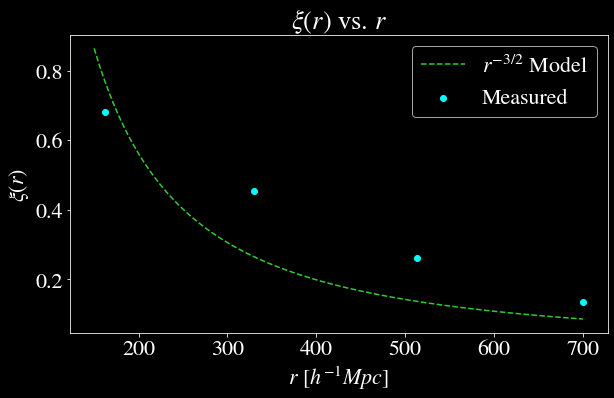

In [34]:
x_model = np.linspace(150,700,100)

f, (ax1) = plt.subplots(1,1, figsize=(9,6))

ax1.set_title('$\\xi(r)$ vs. $r$')
ax1.plot(x_model, model(x_model, b),
         color='limegreen',linestyle='--',
         label='$r^{-3/2}$ Model')
ax1.scatter(rs, corrs, color='cyan', label='Measured')
ax1.set_xlabel('$r$ [$h^{-1} Mpc$]')
ax1.set_ylabel('$\\xi(r)$')
ax1.legend()
f.tight_layout()
plt.show()

## Save the input power spectrum and k

In [50]:
# k = np.linspace(1e-3, 1e0, 1000)
# input_linear_pk = grf.Plin(k)

k = np.logspace(-3, 0, 1000)
input_linear_pk = grf.Plin(k)

configs=np.array([k, input_linear_pk])
np.save('grf_configs.npy', configs)

## Save 2PCF Coefficients

In [51]:
two_pcf_data = np.array([rs,corrs])
np.save('grf_2pcf.npy', two_pcf_data)

## Run Jiamin's 4PCF Code

In [52]:
from model_4PCF_Gaussian_isotropic_basis import model_4PCF
from example_NPCF_utils import GetCoeffCpp

In [53]:
fdir = '/Users/jamessunseri/Desktop/uf_reu/4pcf_ISM/Testing/'
npcf = 4
zetas = GetCoeffCpp(fdir,npcf)

zetas.load_mhd()

_4pcf_model = model_4PCF(zetas)

_4pcf_model.run()

load existing Pk
load existing xi


In [54]:
np.shape(_4pcf_model.zetas_dict['000'])

(4, 4, 4)

In [58]:
def make_plot(ells='000', b_1=0, b_2=0, b_3=0,xylabel_fontsize = 22,
    sub_title_fontsize = 22, sup_title_fontsize = 30,
    text_fontsize = 30, upper_bound = 5e-10,
    lower_bound = -1e-10, colorbar_ax_percent = '5%', nbins=4, ax=None):
    if ells in list(_4pcf_model.zetas_dict.keys()):
        if ax is not None:
#         f, (ax1) = plt.subplots(1,1, figsize=(9,9))
            zeta = _4pcf_model.zetas_dict[ells]
            ells_string = '$\ell_1, \ell_2, \ell_3 =$ ' + ells[0] + ',' + ells[1] + ',' + ells[2]
#             f.suptitle('4PCF coefficients $\\zeta^{b_1 b_2 b_3}_{\ell_1 \ell_2 \ell_3}$', fontsize=sup_title_fontsize)
            im1 = ax.imshow(zeta[:,b_2,:].real, origin='lower')
            ax.text(0,nbins-1, ells_string, c='white', fontsize=text_fontsize)
            ax.set_title('$b_2$ = ' + str(b_2), fontsize=sub_title_fontsize)
            ax.set_xticks(range(nbins))
            ax.set_yticks(range(nbins))
            ax.set_xlabel("$b_1$",fontsize=xylabel_fontsize)
            ax.set_ylabel("$b_3$", fontsize=xylabel_fontsize)
            divider1 = axgrid.make_axes_locatable(ax)
            cax1 = divider1.append_axes("right", size=colorbar_ax_percent, pad=0.05)
            plt.colorbar(im1, cax=cax1)
            #im1.set_clim(lower_bound, upper_bound)
        else:
            f, (ax1) = plt.subplots(1,1, figsize=(9,9))
            zeta = _4pcf_model.zetas_dict[ells]
            ells_string = '$\ell_1, \ell_2, \ell_3 =$ ' + ells[0] + ',' + ells[1] + ',' + ells[2]
            f.suptitle('4PCF coefficients $\\zeta^{b_1 b_2 b_3}_{\ell_1 \ell_2 \ell_3}$', fontsize=sup_title_fontsize)

            im1 = ax1.imshow(zeta[:,b_2,:].real, origin='lower')
            ax1.text(0,nbins-1, ells_string, c='white', fontsize=text_fontsize)
            ax1.set_title('$b_2$ = ' + str(b_2), fontsize=sub_title_fontsize)
            ax1.set_xticks(range(nbins))
            ax1.set_yticks(range(nbins))
            ax1.set_xlabel("$b_1$",fontsize=xylabel_fontsize)
            ax1.set_ylabel("$b_3$", fontsize=xylabel_fontsize)
            divider1 = axgrid.make_axes_locatable(ax1)
            cax1 = divider1.append_axes("right", size=colorbar_ax_percent, pad=0.05)
            plt.colorbar(im1, cax=cax1)
            #im1.set_clim(lower_bound, upper_bound)
            
    else:
        if ax is not None:
#         f, (ax1) = plt.subplots(1,1, figsize=(9,9))
            zeta = np.zeros((4,4,4))
            ells_string = '$\ell_1, \ell_2, \ell_3 =$ ' + "Invalid Combination"
#             f.suptitle('4PCF coefficients $\\zeta^{b_1 b_2 b_3}_{\ell_1 \ell_2 \ell_3}$', fontsize=sup_title_fontsize)
            im1 = ax.imshow(zeta[:,b_2,:].real, origin='lower')
            ax.text(0,nbins-1, ells_string, c='white', fontsize=text_fontsize)
            ax.set_title('$b_2$ = ' + str(b_2), fontsize=sub_title_fontsize)
            ax.set_xticks(range(nbins))
            ax.set_yticks(range(nbins))
            ax.set_xlabel("$b_1$",fontsize=xylabel_fontsize)
            ax.set_ylabel("$b_3$", fontsize=xylabel_fontsize)
            divider1 = axgrid.make_axes_locatable(ax)
            cax1 = divider1.append_axes("right", size=colorbar_ax_percent, pad=0.05)
            plt.colorbar(im1, cax=cax1)
            #im1.set_clim(lower_bound, upper_bound)
        else:
            f, (ax1) = plt.subplots(1,1, figsize=(9,9))
            zeta = np.zeros((4,4,4))
            ells_string = '$\ell_1, \ell_2, \ell_3 =$ ' + "Invalid Combination"
            f.suptitle('4PCF coefficients $\\zeta^{b_1 b_2 b_3}_{\ell_1 \ell_2 \ell_3}$', fontsize=sup_title_fontsize)

            im1 = ax1.imshow(zeta[:,b_2,:].real, origin='lower')
            ax1.text(0,nbins-1, ells_string, c='white', fontsize=text_fontsize)
            ax1.set_title('$b_2$ = ' + str(b_2), fontsize=sub_title_fontsize)
            ax1.set_xticks(range(nbins))
            ax1.set_yticks(range(nbins))
            ax1.set_xlabel("$b_1$",fontsize=xylabel_fontsize)
            ax1.set_ylabel("$b_3$", fontsize=xylabel_fontsize)
            divider1 = axgrid.make_axes_locatable(ax1)
            cax1 = divider1.append_axes("right", size=colorbar_ax_percent, pad=0.05)
            plt.colorbar(im1, cax=cax1)
            #im1.set_clim(lower_bound, upper_bound)


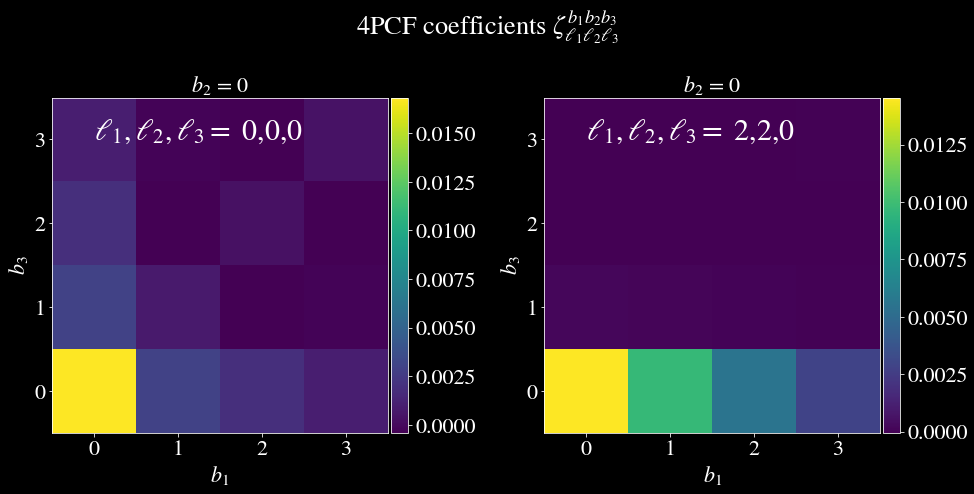

In [66]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(14,7))
f.suptitle('4PCF coefficients $\\zeta^{b_1 b_2 b_3}_{\ell_1 \ell_2 \ell_3}$')
make_plot(ells='000', b_2=0, ax = ax1)
make_plot(ells='220', b_2=0, ax = ax2)
f.tight_layout()

# Scratch Work

# Starting from Scratch

### Create a GRF using an Nmesh = 256

### Measure Power Spectrum
We do this both without converting to catalog and with converting to catalog first. We are seeing if this introduces notable errors

### Compare to Interpolated Galaxy Spectrum and the Input Spectrum

In [84]:
# Nmesh = 256
# cdir =  '/Users/jamessunseri/desktop/uf_reu/4pcf_ISM/Testing/'
# Pk_in = None
# cname = cdir + 'deltar3.npy'

# grf_3 = GenerateGRF(Nmesh, Pk_in=Pk_in, do_inv_phase=True, cname=cname)
# grf_3.run_mk_catalog_grf_weighted(do_save_catalog=True)

In [85]:
# data3 = np.load('deltar3.npy')
# print("Loading in our GRF, it has dimensions of " + str(np.shape(data3)))

In [86]:
# data3_Mesh = ArrayMesh(data3, BoxSize=1574)



In [87]:
# k = np.logspace(-3,0,1000)
# power_spectrum = grf_3.Plin.__call__(k)
# pk_gal_interp = grf_3.Pk_gal_interp(k)
# plt.figure(figsize=(12,8))
# plt.title("Power Spectrum in Log-Scale")
# plt.loglog(k, power_spectrum, color='red',label='Input')
# plt.loglog(k, pk_gal_interp,color='limegreen', label='pk_gal_interp')
# plt.loglog((Pk['k']), (Pk['power'].real - Pk.attrs['shotnoise']),color='cyan', label='Measured')
# plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
# plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
# plt.legend()
# plt.show()

### Now we are ready to make a deltar.npy file that has a new scaling to make sure $\zeta \propto P(k)^2$

In [88]:
# Nmesh = 64
# cdir =  '/Users/jamessunseri/desktop/uf_reu/4pcf_ISM/Testing/'
# Pk_in = None
# cname = cdir + 'deltar_double_scale.npy'

# grf_4 = GenerateGRF(Nmesh, Pk_in=Pk_in, do_inv_phase=True, cname=cname)
# grf_4.bias = 6.6 # effectively shifting P(k) by a factor of 3
# grf_4.run_mk_catalog_grf_weighted(do_save_catalog=True)

In [62]:
# _2PCF = _2pcf.BasePairCount2PCF(mode='1d', data1 = GRF_Catalog, edges = list(bin_edges))
# _2PCF.attrs['config'] = 'ext'


In [90]:
# _2PCF_result = _2PCF.run()

## Visualizing the Power Spectrum

In [7]:
# k = np.logspace(-3,0,1000)
# power_spectrum = grf.Plin.__call__(k)
# pk_gal_interp = grf.Pk_gal_interp(k)
# plt.figure(figsize=(12,8))
# plt.title("Power Spectrum in Log-Scale")
# plt.loglog(k, power_spectrum, color='red', label='Input')
# plt.loglog(k, pk_gal_interp, color='limegreen', label='pk_gal_interp')
# plt.loglog((Pk['k']), (Pk['power'].real - Pk.attrs['shotnoise']), color='cyan', label='Measured')
# plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
# plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
# plt.legend()
# plt.show()

Interesting, these seem really close but not perfectly overlapping. Not sure what is causing this yet!

## Doing it using `pk_to_xi` function from `nbodykit.cosmology.correlation`

In [91]:
# k = np.logspace(-3,0,128)

# #len(Pk['power'])

# xi = pk_to_xi(k, Pk['power'].real, ell=2)

In [159]:
# r = np.linspace(1,100,1000)

# plt.figure(figsize=(12,8))
# plt.loglog(r,r**2 * xi(r))
# plt.title("$r^2 \\xi_{\ell = 0}(r)$ vs. $r$")
# plt.xlabel("$r$ [$h^{-1}$ Mpc]")
# plt.ylabel("$r^2 \\xi(r)$")
# plt.show()


In [89]:
# xylabel_fontsize = 22
# sub_title_fontsize = 22
# sup_title_fontsize = 30
# text_fontsize = 18

# r_1 = np.linspace(1,20,1000)
# r_2 = np.linspace(20, 200, 1000)
# r_3 = np.linspace(200, 1500, 1000)

# f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

# ax1.set_title('$\\xi(r)$ vs. $r$')
# ax1.plot(r_1, xi(r_1), color='cyan')
# ax1.set_xlabel('$r$ [$h^{-1} Mpc$]')
# ax1.set_ylabel('$\\xi(r)$')

# ax2.set_title('$r^2 \\xi(r)$ vs. $r$')
# ax2.plot(r_2, r**2 * xi(r_2), color='cyan')
# ax2.set_xlabel('$r$ [$h^{-1} Mpc$]')
# ax2.set_ylabel('$r^2 \\xi(r)$')

# ax3.set_title('$\\xi(r)$ vs. $r$')
# ax3.plot(r_3, xi(r_3), color='cyan')
# ax3.set_xlabel('$r$ [$h^{-1} Mpc$]')
# ax3.set_ylabel('$\\xi(r)$')
# f.tight_layout()